In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from modules.shared.data_loader import get_stock_data, get_stock_name
from modules.forecasting.predict import ForecastingModel, calculate_metrics

plt.style.use("seaborn-v0_8-whitegrid")

def backtest_walk_forward(
    stock_code: str,
    test_start: str,
    test_end: str,
    train_window_days: int = 50,
    model_type: str = "auto",
    min_volume: int = 1,
):
    """
    Walk-forward backtest (1-step ahead):
      For each date in test period:
        train on previous train_window_days
        predict next day (1 day)
    Returns dataframe with actual/pred/lower/upper.
    """
    df = get_stock_data(stock_code, min_volume=min_volume).sort_values("date").reset_index(drop=True)

    mask = (df["date"] >= pd.to_datetime(test_start)) & (df["date"] <= pd.to_datetime(test_end))
    test_df = df.loc[mask].copy().reset_index(drop=True)
    if len(test_df) < 10:
        raise ValueError(f"Test period too small: {len(test_df)} rows. Check dates.")

    preds, lows, highs, used_models, dates = [], [], [], [], []

    for d in test_df["date"]:
        idxs = df.index[df["date"] == d]
        if len(idxs) == 0:
            continue
        idx = int(idxs[0])

        if idx < train_window_days:
            continue

        train_slice = df.iloc[idx-train_window_days:idx].copy()
        fm = ForecastingModel(model_type=model_type)
        fit_res = fm.fit(train_slice)

        pred1 = fm.predict(1).iloc[0]

        dates.append(d)
        preds.append(float(pred1["predicted_close"]))
        lows.append(float(pred1.get("lower_bound", np.nan)))
        highs.append(float(pred1.get("upper_bound", np.nan)))
        used_models.append(fit_res.model_used)

    # Align actuals with predicted dates
    out = pd.DataFrame({
        "date": pd.to_datetime(dates),
        "predicted": preds,
        "lower": lows,
        "upper": highs,
    })
    out = out.merge(df[["date", "close"]], on="date", how="left").rename(columns={"close": "actual"})
    out = out.sort_values("date").reset_index(drop=True)

    metrics = calculate_metrics(out["actual"], out["predicted"])
    model_counts = pd.Series(used_models).value_counts().to_dict()

    return out, metrics, model_counts


def plot_backtest_forecast(
    stock_code: str,
    test_start: str,
    test_end: str,
    train_window_days: int = 50,
    model_type: str = "auto",
    min_volume: int = 1,
    save_png: bool = True,
):
    stock_name = get_stock_name(stock_code)

    out, metrics, model_counts = backtest_walk_forward(
        stock_code=stock_code,
        test_start=test_start,
        test_end=test_end,
        train_window_days=train_window_days,
        model_type=model_type,
        min_volume=min_volume,
    )

    fig, axes = plt.subplots(2, 1, figsize=(15, 9), gridspec_kw={"height_ratios": [3, 1]})

    # Main plot
    ax = axes[0]
    ax.plot(out["date"], out["actual"], label="Réel (Close)", color="blue", linewidth=2)
    ax.plot(out["date"], out["predicted"], label="Prévu (1-step walk-forward)", color="orange",
            linewidth=2, linestyle="--", marker="o", markersize=3)

    # Confidence interval band (if not all NaN)
    if out["lower"].notna().any() and out["upper"].notna().any():
        ax.fill_between(out["date"], out["lower"], out["upper"], color="orange", alpha=0.2,
                        label="Intervalle de confiance (approx/CI)")

    ax.set_title(
        f"{stock_name} ({stock_code}) | model={model_type} | window={train_window_days} jours\n"
        f"Test: {test_start} → {test_end} | RMSE={metrics['rmse']} | MAE={metrics['mae']} | "
        f"MAPE={metrics['mape']}% | DirAcc={metrics['directional_accuracy']}%\n"
        f"Models used (auto): {model_counts}",
        fontsize=11, fontweight="bold"
    )
    ax.set_ylabel("Prix (TND)")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

    # Error plot
    err = out["actual"].values - out["predicted"].values
    ax2 = axes[1]
    colors = ["green" if e >= 0 else "red" for e in err]
    ax2.bar(out["date"], err, color=colors, alpha=0.7)
    ax2.axhline(0, color="black", linewidth=0.8)
    ax2.set_ylabel("Erreur (Réel - Prévu)")
    ax2.set_xlabel("Date")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_png:
        Path("outputs").mkdir(exist_ok=True)
        filename = f"outputs/backtest_{stock_code}_{test_start}_to_{test_end}_{model_type}.png"
        filename = filename.replace(":", "-")
        plt.savefig(filename, dpi=160, bbox_inches="tight")
        print("Saved:", filename)

    plt.show()
    return out, metrics, model_counts

In [17]:
def backtest_train_once_plot(
    stock_code: str,
    train_end: str = "2025-09-30",
    test_start: str = "2025-10-01",
    test_end: str = "2025-12-31",
    model_type: str = "prophet",
    min_volume: int = 1,
    save_png: bool = True
):
    import pandas as pd
    import matplotlib.pyplot as plt
    from pathlib import Path

    df = get_stock_data(stock_code, min_volume=min_volume).sort_values("date").reset_index(drop=True)
    name = get_stock_name(stock_code)

    train_df = df[df["date"] <= pd.to_datetime(train_end)].copy()
    test_df = df[(df["date"] >= pd.to_datetime(test_start)) & (df["date"] <= pd.to_datetime(test_end))].copy()

    if len(train_df) < 60 or len(test_df) < 10:
        raise ValueError("Not enough data for train/test split.")

    fm = ForecastingModel(model_type=model_type, max_train_time=120)  # allow Prophet once
    fm.fit(train_df)
    pred = fm.predict(len(test_df)).copy()

    # align (dates should match, but we merge to be safe)
    pred = pred.rename(columns={"predicted_close": "pred"})
    pred["date"] = pd.to_datetime(pred["date"])
    merged = test_df.merge(pred[["date", "pred", "lower_bound", "upper_bound"]], on="date", how="left")

    metrics = calculate_metrics(merged["close"], merged["pred"])

    plt.figure(figsize=(15,6))
    plt.plot(merged["date"], merged["close"], label="Actual", linewidth=2)
    plt.plot(merged["date"], merged["pred"], label="Predicted", linewidth=2, linestyle="--")

    if merged["lower_bound"].notna().any():
        plt.fill_between(merged["date"], merged["lower_bound"], merged["upper_bound"], alpha=0.2, label="Confidence interval")

    plt.title(f"Backtest (train once): {name} ({stock_code}) | model={model_type} | RMSE={metrics['rmse']} | MAE={metrics['mae']} | DirAcc={metrics['directional_accuracy']}%")
    plt.xlabel("Date")
    plt.ylabel("Price (TND)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_png:
        Path("outputs").mkdir(exist_ok=True)
        path = f"outputs/backtest_train_once_{stock_code}_{model_type}.png"
        plt.savefig(path, dpi=160, bbox_inches="tight")
        print("Saved:", path)

    plt.show()
    return merged, metrics

Saved: outputs/backtest_train_once_TN0007400013_arima.png


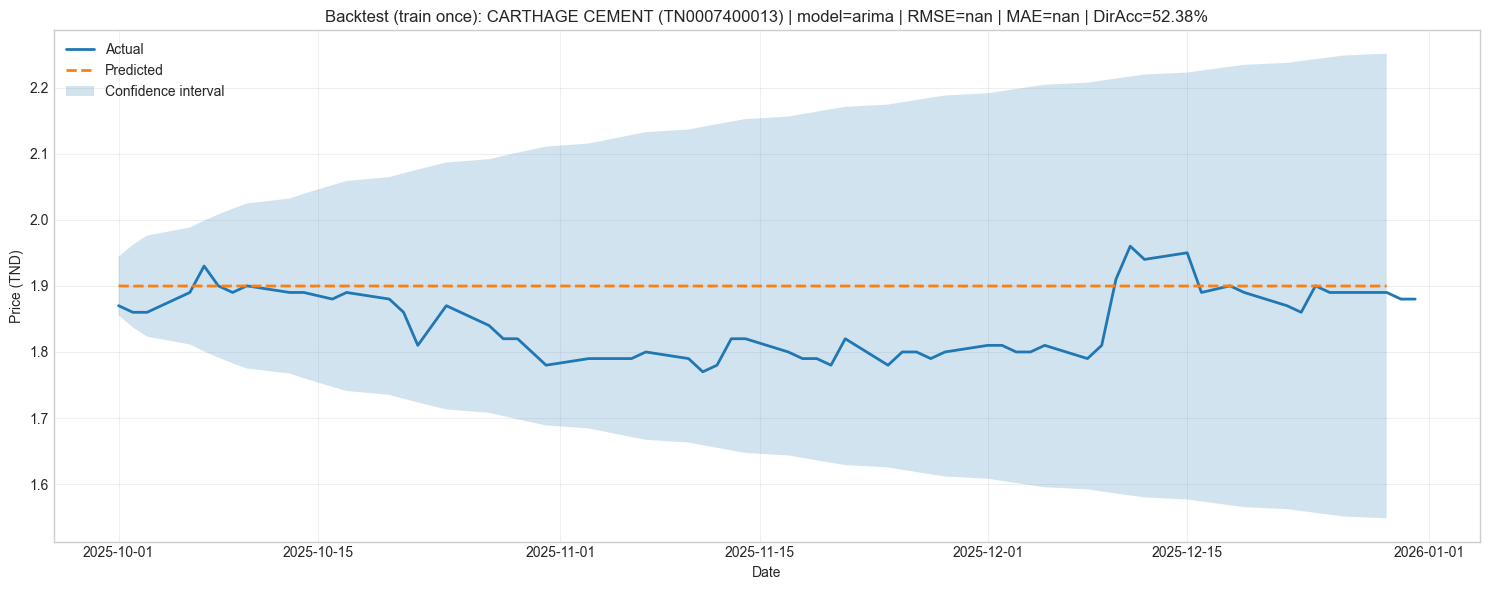

{'rmse': nan, 'mae': nan, 'mape': nan, 'directional_accuracy': 52.38}


In [19]:
merged, metrics = backtest_train_once_plot(
    stock_code="TN0007400013",
    train_end="2025-09-30",
    test_start="2025-10-01",
    test_end="2025-12-31",
    model_type="arima",
    min_volume=1
)
print(metrics)

In [21]:
def run_backtest_and_show(
    stock_code: str,
    test_start: str,
    test_end: str,
    train_window_days: int = 50,
    model_type: str = "arima",
    min_volume: int = 1,
    save_png: bool = True,
    show_head: bool = True,
    head_n: int = 5,
):
    """
    Wrapper pratique:
    - Lance le backtest + plot
    - Print metrics + models_used
    - Affiche out.head()
    - Retourne (out, metrics, models_used)
    """
    out, metrics, models_used = plot_backtest_forecast(
        stock_code=stock_code,
        test_start=test_start,
        test_end=test_end,
        train_window_days=train_window_days,
        model_type=model_type,
        min_volume=min_volume,
        save_png=save_png
    )

    print("=== METRICS ===")
    print(metrics)
    print("\n=== MODELS USED ===")
    print(models_used)

    if show_head:
        display(out.head(head_n))  # display est fourni par Jupyter

    return out, metrics, models_used

Saved: outputs/backtest_TN0001100254_2025-10-01_to_2025-12-31_arima.png


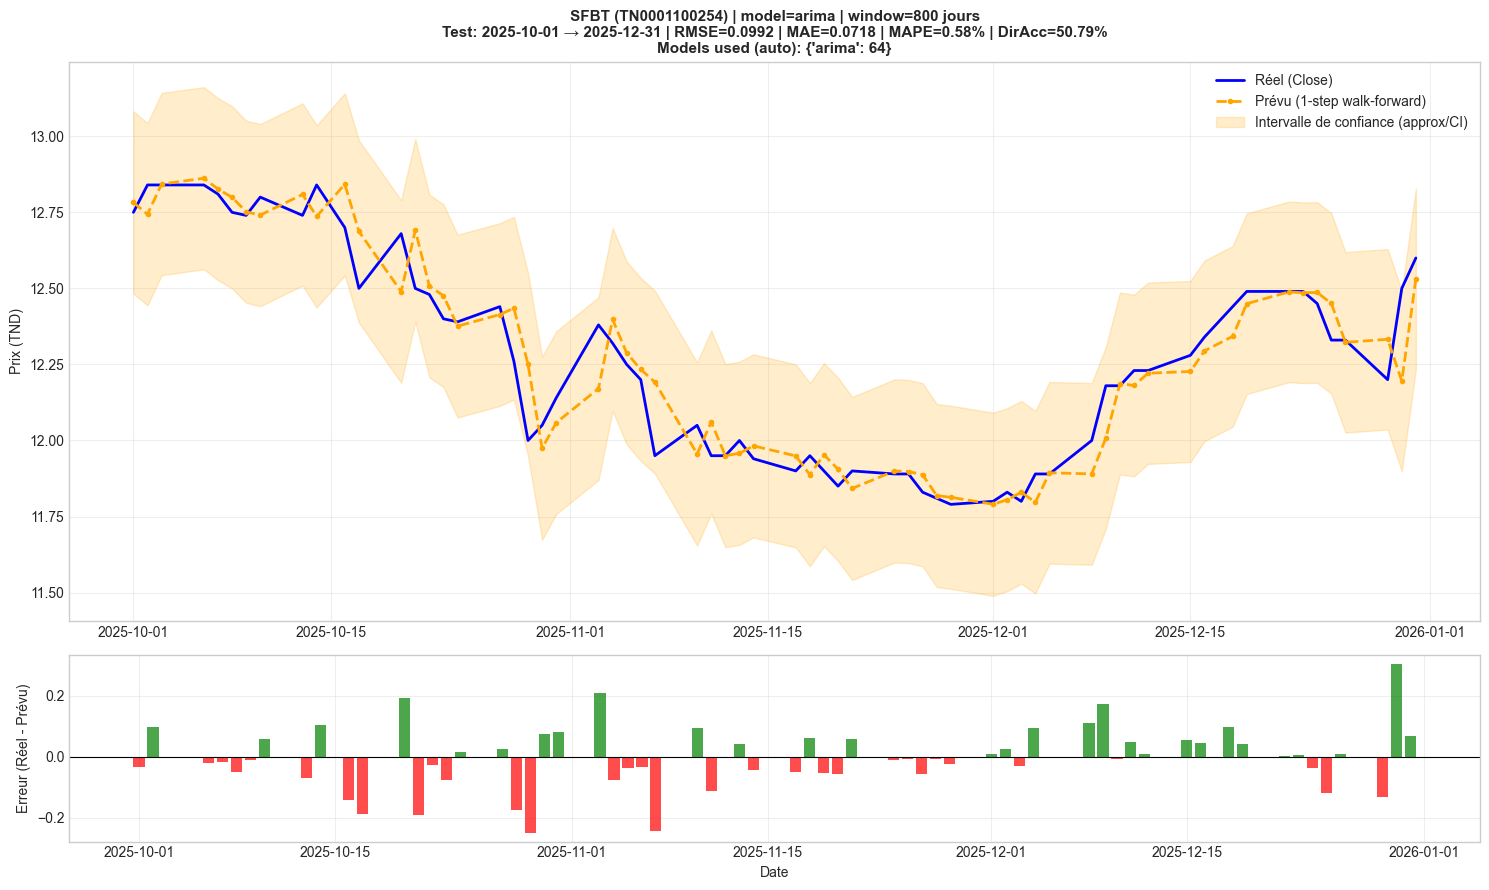

=== METRICS ===
{'rmse': 0.0992, 'mae': 0.0718, 'mape': 0.58, 'directional_accuracy': 50.79}

=== MODELS USED ===
{'arima': 64}


,date,predicted,lower,upper,actual
0,2025-10-01,12.782442,12.482981,13.081904,12.75
1,2025-10-02,12.743718,12.444276,13.043160,12.84
2,2025-10-03,12.842924,12.543473,13.142375,12.84
3,2025-10-06,12.862010,12.562593,13.161427,12.84
4,2025-10-07,12.826432,12.527049,13.125815,12.81


In [23]:
out, metrics, models_used = run_backtest_and_show(
    stock_code="TN0001100254",
    test_start="2025-10-01",
    test_end="2025-12-31",
    train_window_days=800,
    model_type="arima",
    min_volume=1,
    save_png=True
)

Saved: outputs/backtest_TN0001900604_2025-10-01_to_2025-12-31_arima.png


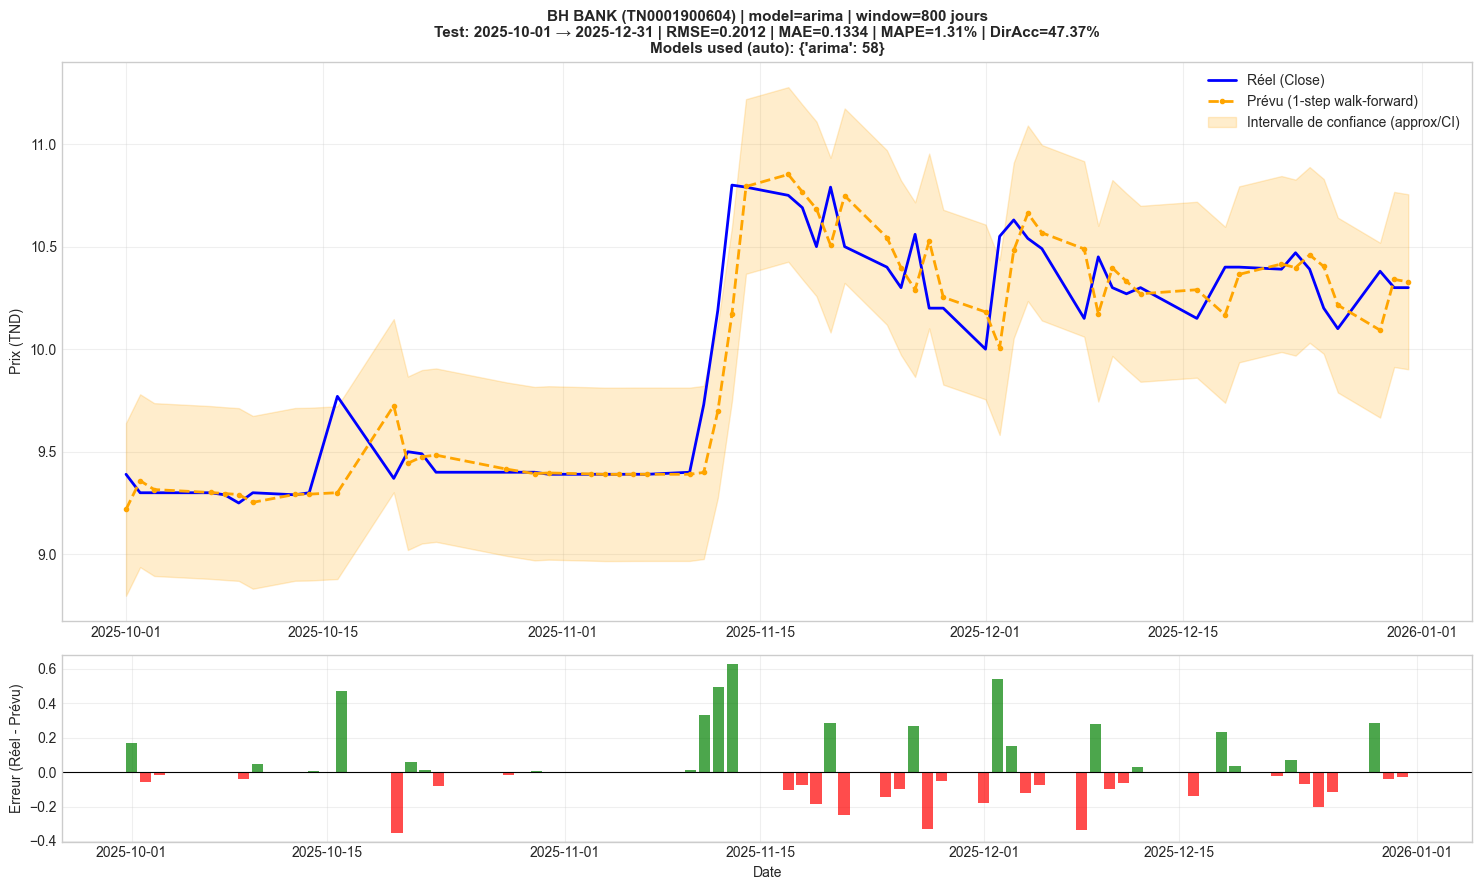

=== METRICS ===
{'rmse': 0.2012, 'mae': 0.1334, 'mape': 1.31, 'directional_accuracy': 47.37}

=== MODELS USED ===
{'arima': 58}


,date,predicted,lower,upper,actual
0,2025-10-01,9.218937,8.797577,9.640296,9.39
1,2025-10-02,9.358695,8.937369,9.780021,9.30
2,2025-10-03,9.315517,8.894172,9.736861,9.30
3,2025-10-07,9.301247,8.879896,9.722598,9.30
4,2025-10-08,9.296010,8.874848,9.717172,9.29


In [24]:
out, metrics, models_used = run_backtest_and_show(
    stock_code="TN0001900604",
    test_start="2025-10-01",
    test_end="2025-12-31",
    train_window_days=800,
    model_type="arima",
    min_volume=1,
    save_png=True
)